### Predicting Future Sales 
<b>Using Deep Learning for Time Series Forecasting</b>

Working with a daily historical sales data to forecast the total amount of products sold in every shop for the test set. List of shops and products slightly changes every month, so there's a need to create a robust model that can handle such situations. 

Data Source: https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data

<b>Importing required packages and loading the data:</b>

In [27]:
import warnings
warnings.filterwarnings("ignore")
import glob
import zipfile
import os

import pandas as pd
import seaborn as sns
from datetime import datetime, date

In [13]:
train = pd.read_csv("data2/train.csv")
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [15]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [221]:
test = pd.read_csv("data2/test.csv")
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [222]:
test = test.drop(['id'], axis=1)

In [223]:
test.describe()

,store,item
count,45000.000000,45000.00000
mean,5.500000,25.50000
std,2.872313,14.43103
min,1.000000,1.00000
25%,3.000000,13.00000
50%,5.500000,25.50000
75%,8.000000,38.00000
max,10.000000,50.00000


In [19]:
train.shape, test.shape

((913000, 4), (45000, 4))

Clearly, we have a huge data so we need to move to some sophisticated methods for prediction. Time series forecasting is challenging, especially when working with long sequences, noisy data, multi-step forecasts and multiple input and output variables.

Deep learning methods offer a lot of promise for time series forecasting, such as the automatic learning of temporal dependence and the automatic handling of temporal structures like trends and seasonality.

In [24]:
min(train['date']), max(train['date'])

('2013-01-01', '2017-12-31')

In [25]:
min(test['date']), max(test['date'])

('2018-01-01', '2018-03-31')

<b>Finding the gap between last day of train set and last day of test test:</b>

In [36]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

lag = days_between(max(test['date']), max(train['date']))
lag

90

<b>Data Exploration:</b>

In [40]:
train['date'].nunique()

1826

<AxesSubplot: title={'center': 'Total Sales vs Date'}, xlabel='Date', ylabel='Sales'>

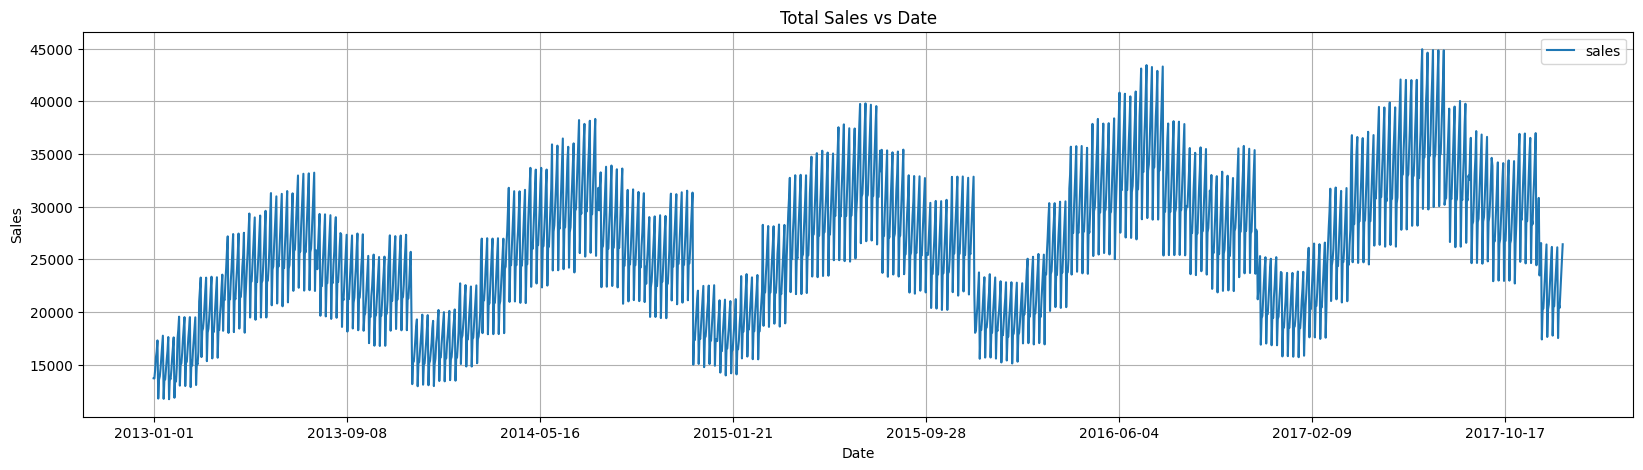

In [48]:
temp = train[['sales', 'date']].groupby(['date']).sum()
temp.plot(figsize = (20, 5), title = "Total Sales vs Date", grid = True, 
                                                      ylabel = 'Sales', xlabel = 'Date')

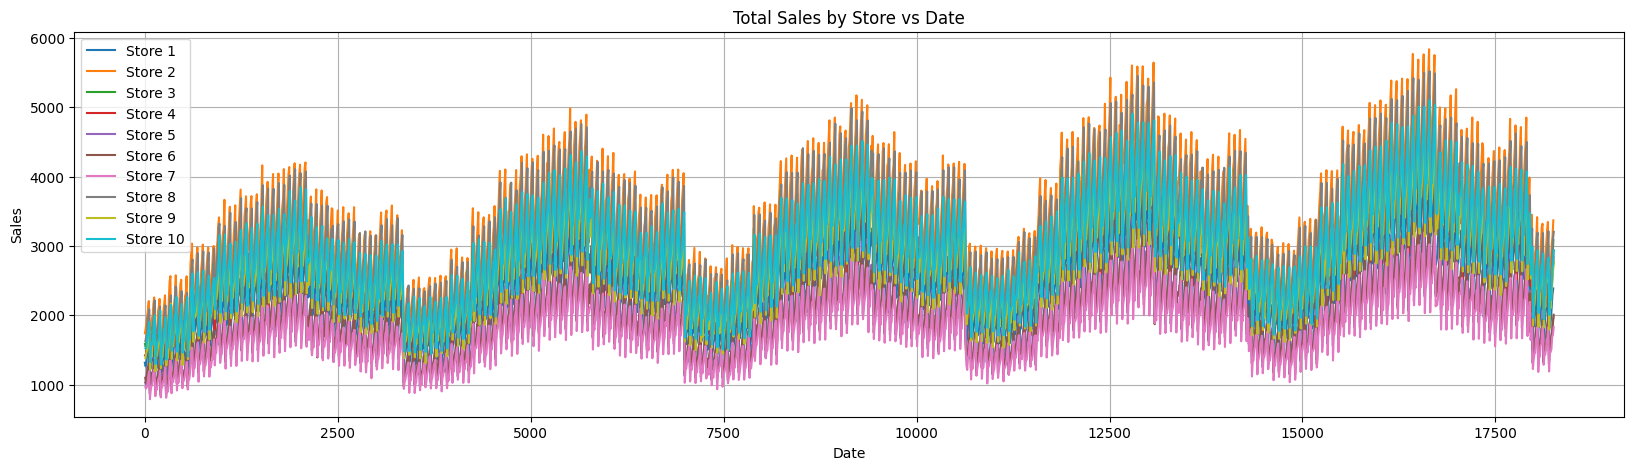

In [102]:
temp = train[['date', 'store', 'sales']].groupby(['date', 'store'], as_index=False).sum()

fig = plt.figure()
ax1 = fig.add_subplot(111)

for store in temp['store'].unique():
    temp2 = temp[(temp['store'] == store)]
    temp2['sales'].plot(figsize = (20, 5), ax = ax1, grid = True, title = 'Total Sales by Store vs Date', 
                                   ylabel = 'Sales', xlabel = 'Date')

ax1.legend(['Store 1', 'Store 2', 'Store 3', 'Store 4', 'Store 5', 'Store 6', 
                                                        'Store 7', 'Store 8', 'Store 9', 'Store 10'])

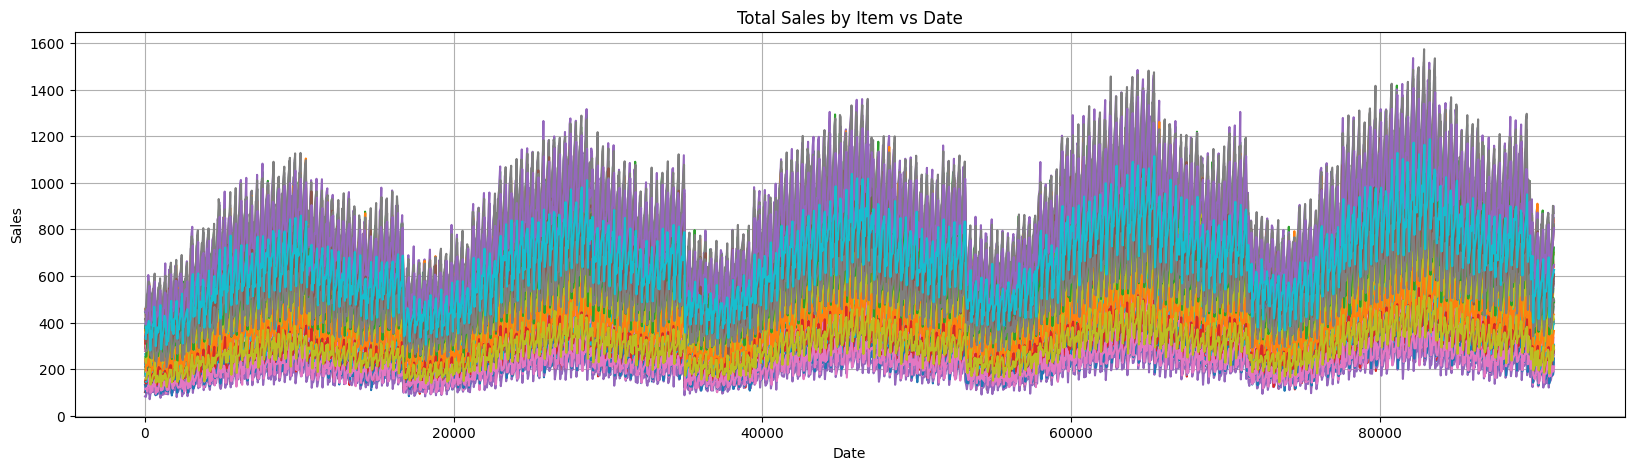

In [120]:
temp = train[['date', 'item', 'sales']].groupby(['date', 'item'], as_index=False).sum()

fig = plt.figure()
ax1 = fig.add_subplot(111)

for store in temp['item'].unique():
    temp2 = temp[(temp['item'] == store)]
    temp2['sales'].plot(figsize = (20, 5), ax = ax1, grid = True, title = 'Total Sales by Item vs Date', 
                                   ylabel = 'Sales', xlabel = 'Date')

<b>Sub-sampling the training dataset to get last one year of data:</b>

In [109]:
train2 = train[(train['date'] >= '2017-01-01')]

<b>Re-arranging the data to apply shift methods:</b>

In [122]:
train3 = train2.sort_values('date').groupby(['item', 'store', 'date'], as_index = False)
train3 = train3.agg({'sales': ['mean']})
train3.columns = ['item', 'store', 'date', 'sales']
train3.head()

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0


<b>Transforming the data into a Time Series problem:</b>

In [134]:
def series_to_supervised(data, window = 1, lag = 1, dropnan = True):
    
    cols, names = list(), list()
    
    # Input Sequence --> t-n, ... , t-1
    
    for i in range(window, 0, -1):
        cols.append(data.shift(i)) # appending dfs to list               
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
        
    # Current Timestep (t = 0)
    
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    
    # Target Timestep (t = lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    # Putting all together 
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    # Drop rows with NaN values 
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg 

<b>Using the current timestep and the last 29 days to forecast 90 days ahead:</b>

In [141]:
window, lag = 29, lag
series = series_to_supervised(train3.drop('date', axis = 1), window = window, lag = lag)
print(series.shape)
series.iloc[:, 0:12].head()

# item | store | sales 

(182381, 93)


,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),store(t-26),sales(t-26)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0


<b>Dropping rows with different item or store values than the shifted columns:</b>

In [142]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window

series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [146]:
last_item, last_store, series.shape

('item(t-29)', 'store(t-29)', (167910, 93))

<b>Removing unwanted columns:</b>

In [147]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]

for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
    
series.drop(columns_to_drop, axis = 1, inplace = True)
series.drop(['item(t)', 'store(t)'], axis = 1, inplace = True)

In [148]:
series.shape

(167910, 31)

<b>Splitting the final df into train and validation set:</b>

In [154]:
from sklearn.model_selection import train_test_split

labels_col = 'sales(t+%d)' % lag
labels = series[labels_col]

series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, 
                                                                  test_size = 0.4, random_state = 0)
print('Train Set Shape', X_train.shape)
print('Validation Set Shape', X_valid.shape)

X_train.iloc[:, 0:12].head()

Train Set Shape (100746, 30)
Validation Set Shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,121.0,136.0
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,37.0,36.0
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,55.0,64.0
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,112.0,110.0
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,78.0,95.0


### It's time for 'Time Series Forecasting'

<b>MLP</b> \
Starting with Multi-Layer Perceptron. Input features for the model will be equal to window size. MLPs don't take the input as sequenced data, so our model might now see the data with the sequenced pattern it has. Input shape: [Samples, Timesteps]

In [157]:
from keras import optimizers

epochs, batch, lr = 40, 256, 0.0003  # lr --> learning rate 
adam = optimizers.Adam(lr) 

In [160]:
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error

model_mlp = Sequential()
model_mlp.add(Dense(100, activation = 'relu', input_dim = X_train.shape[1]))
model_mlp.add(Dense(1))

model_mlp.compile(loss = 'mse', optimizer = adam)
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [161]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data = (X_valid.values, Y_valid), 
                                        epochs = epochs, verbose = 2)

Epoch 1/40
3149/3149 - 4s - loss: 408.2503 - val_loss: 375.7420 - 4s/epoch - 1ms/step
Epoch 2/40
3149/3149 - 3s - loss: 371.9495 - val_loss: 368.3307 - 3s/epoch - 1ms/step
Epoch 3/40
3149/3149 - 4s - loss: 362.7307 - val_loss: 355.7943 - 4s/epoch - 1ms/step
Epoch 4/40
3149/3149 - 3s - loss: 359.0281 - val_loss: 369.8521 - 3s/epoch - 1ms/step
Epoch 5/40
3149/3149 - 3s - loss: 356.0877 - val_loss: 352.1161 - 3s/epoch - 1ms/step
Epoch 6/40
3149/3149 - 3s - loss: 354.3918 - val_loss: 362.5335 - 3s/epoch - 1ms/step
Epoch 7/40
3149/3149 - 3s - loss: 353.7271 - val_loss: 350.5248 - 3s/epoch - 1ms/step
Epoch 8/40
3149/3149 - 3s - loss: 351.9971 - val_loss: 360.3477 - 3s/epoch - 1ms/step
Epoch 9/40
3149/3149 - 3s - loss: 352.3735 - val_loss: 356.6809 - 3s/epoch - 1ms/step
Epoch 10/40
3149/3149 - 3s - loss: 350.9357 - val_loss: 349.7380 - 3s/epoch - 1ms/step
Epoch 11/40
3149/3149 - 3s - loss: 350.9929 - val_loss: 349.2483 - 3s/epoch - 1ms/step
Epoch 12/40
3149/3149 - 3s - loss: 349.7557 - val_lo

<b>CNN</b>

For the CNN Model, using 1 convolution hidden layer followed by 1 max pooling layer. Filter maps are flattened before being interpreted by a Dense later and generating prediction output. Convolutional layer should be able to identify patterns between the timesteps. Input shape [samples, timesteps, features] 

Also need to reshape from [samples, timesteps] to [sample, timesteps, features]. This will be used for CNN as well as LSTM Model. 

In [162]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [163]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', 
                                 input_shape = (X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size = 2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation = 'relu'))
model_cnn.add(Dense(1))

model_cnn.compile(loss='mse', optimizer = adam)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                44850     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

In [164]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data = (X_valid_series, Y_valid), 
                                                        epochs = epochs, verbose = 2)

Epoch 1/40
3149/3149 - 6s - loss: 414.3019 - val_loss: 396.8320 - 6s/epoch - 2ms/step
Epoch 2/40
3149/3149 - 6s - loss: 382.5884 - val_loss: 383.0807 - 6s/epoch - 2ms/step
Epoch 3/40
3149/3149 - 6s - loss: 371.5094 - val_loss: 368.6802 - 6s/epoch - 2ms/step
Epoch 4/40
3149/3149 - 6s - loss: 368.1411 - val_loss: 360.6570 - 6s/epoch - 2ms/step
Epoch 5/40
3149/3149 - 6s - loss: 364.2939 - val_loss: 359.5550 - 6s/epoch - 2ms/step
Epoch 6/40
3149/3149 - 6s - loss: 361.1771 - val_loss: 376.6151 - 6s/epoch - 2ms/step
Epoch 7/40
3149/3149 - 6s - loss: 360.0535 - val_loss: 364.1597 - 6s/epoch - 2ms/step
Epoch 8/40
3149/3149 - 6s - loss: 358.2482 - val_loss: 353.8920 - 6s/epoch - 2ms/step
Epoch 9/40
3149/3149 - 6s - loss: 357.8825 - val_loss: 358.3805 - 6s/epoch - 2ms/step
Epoch 10/40
3149/3149 - 6s - loss: 356.7635 - val_loss: 354.4422 - 6s/epoch - 2ms/step
Epoch 11/40
3149/3149 - 6s - loss: 355.0166 - val_loss: 361.7450 - 6s/epoch - 2ms/step
Epoch 12/40
3149/3149 - 6s - loss: 354.5851 - val_lo

<b>LSTM</b>

LSTM looks at the input data sequentially and is able to learn patterns from sequenced data [assuming it exists] better than the other models, especially in case of long sequences. Input shape [samples, timesteps, features]

In [166]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation = 'relu', 
                            input_shape = (X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))

model_lstm.compile(loss = 'mse', optimizer = adam)
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [167]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data = (X_valid_series, Y_valid), 
                                                                         epochs = epochs, verbose = 2)

Epoch 1/40
3149/3149 - 39s - loss: 815.5903 - val_loss: 458.0973 - 39s/epoch - 12ms/step
Epoch 2/40
3149/3149 - 33s - loss: 450.9080 - val_loss: 425.8233 - 33s/epoch - 10ms/step
Epoch 3/40
3149/3149 - 32s - loss: 429.5727 - val_loss: 501.5060 - 32s/epoch - 10ms/step
Epoch 4/40
3149/3149 - 32s - loss: 440.4417 - val_loss: 486.6755 - 32s/epoch - 10ms/step
Epoch 5/40
3149/3149 - 32s - loss: 450.9051 - val_loss: 408.9543 - 32s/epoch - 10ms/step
Epoch 6/40
3149/3149 - 32s - loss: 424.5542 - val_loss: 410.6288 - 32s/epoch - 10ms/step
Epoch 7/40
3149/3149 - 32s - loss: 417.0640 - val_loss: 409.5563 - 32s/epoch - 10ms/step
Epoch 8/40
3149/3149 - 32s - loss: 405.9495 - val_loss: 470.4925 - 32s/epoch - 10ms/step
Epoch 9/40
3149/3149 - 32s - loss: 521.5555 - val_loss: 421.4362 - 32s/epoch - 10ms/step
Epoch 10/40
3149/3149 - 32s - loss: 416.5224 - val_loss: 415.1118 - 32s/epoch - 10ms/step
Epoch 11/40
3149/3149 - 32s - loss: 405.2224 - val_loss: 399.2242 - 32s/epoch - 10ms/step
Epoch 12/40
3149/31

<b>CNN-LSTM</b> \
This model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model. When using a hybrid CNN-LSTM model, we further divide each sample into sub-sequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the sub-sequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence. CNN will be defined to accept 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction.

Here, reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features]

In [168]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences

X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))

print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [170]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 1, activation = 'relu'), 
                                           input_shape=(None, X_train_series_sub.shape[2], 
                                                                    X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation = 'relu'))
model_cnn_lstm.add(Dense(1))

model_cnn_lstm.compile M(loss = 'mse', optimizer = adam)

cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, 
                                      validation_data = (X_valid_series_sub, Y_valid), 
                                                                          epochs = epochs, verbose = 2)

Epoch 1/40
3149/3149 - 16s - loss: 452.3197 - val_loss: 429.4336 - 16s/epoch - 5ms/step
Epoch 2/40
3149/3149 - 15s - loss: 426.3219 - val_loss: 419.9250 - 15s/epoch - 5ms/step
Epoch 3/40
3149/3149 - 16s - loss: 417.6852 - val_loss: 424.7646 - 16s/epoch - 5ms/step
Epoch 4/40
3149/3149 - 13s - loss: 414.8842 - val_loss: 410.9931 - 13s/epoch - 4ms/step
Epoch 5/40
3149/3149 - 13s - loss: 414.6452 - val_loss: 418.1560 - 13s/epoch - 4ms/step
Epoch 6/40
3149/3149 - 13s - loss: 415.2136 - val_loss: 417.2224 - 13s/epoch - 4ms/step
Epoch 7/40
3149/3149 - 13s - loss: 413.5267 - val_loss: 414.8593 - 13s/epoch - 4ms/step
Epoch 8/40
3149/3149 - 13s - loss: 412.2989 - val_loss: 408.5138 - 13s/epoch - 4ms/step
Epoch 9/40
3149/3149 - 13s - loss: 406.8568 - val_loss: 400.3397 - 13s/epoch - 4ms/step
Epoch 10/40
3149/3149 - 13s - loss: 398.9885 - val_loss: 392.0195 - 13s/epoch - 4ms/step
Epoch 11/40
3149/3149 - 13s - loss: 391.4693 - val_loss: 390.0350 - 13s/epoch - 4ms/step
Epoch 12/40
3149/3149 - 13s - 

In [183]:
model_cnn_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 15, 64)     128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 7, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 448)        0         
 tributed)                                                       
                                                                 
 lstm_3 (LSTM)               (None, 50)                99800     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                      

<b>Model Comparison</b>

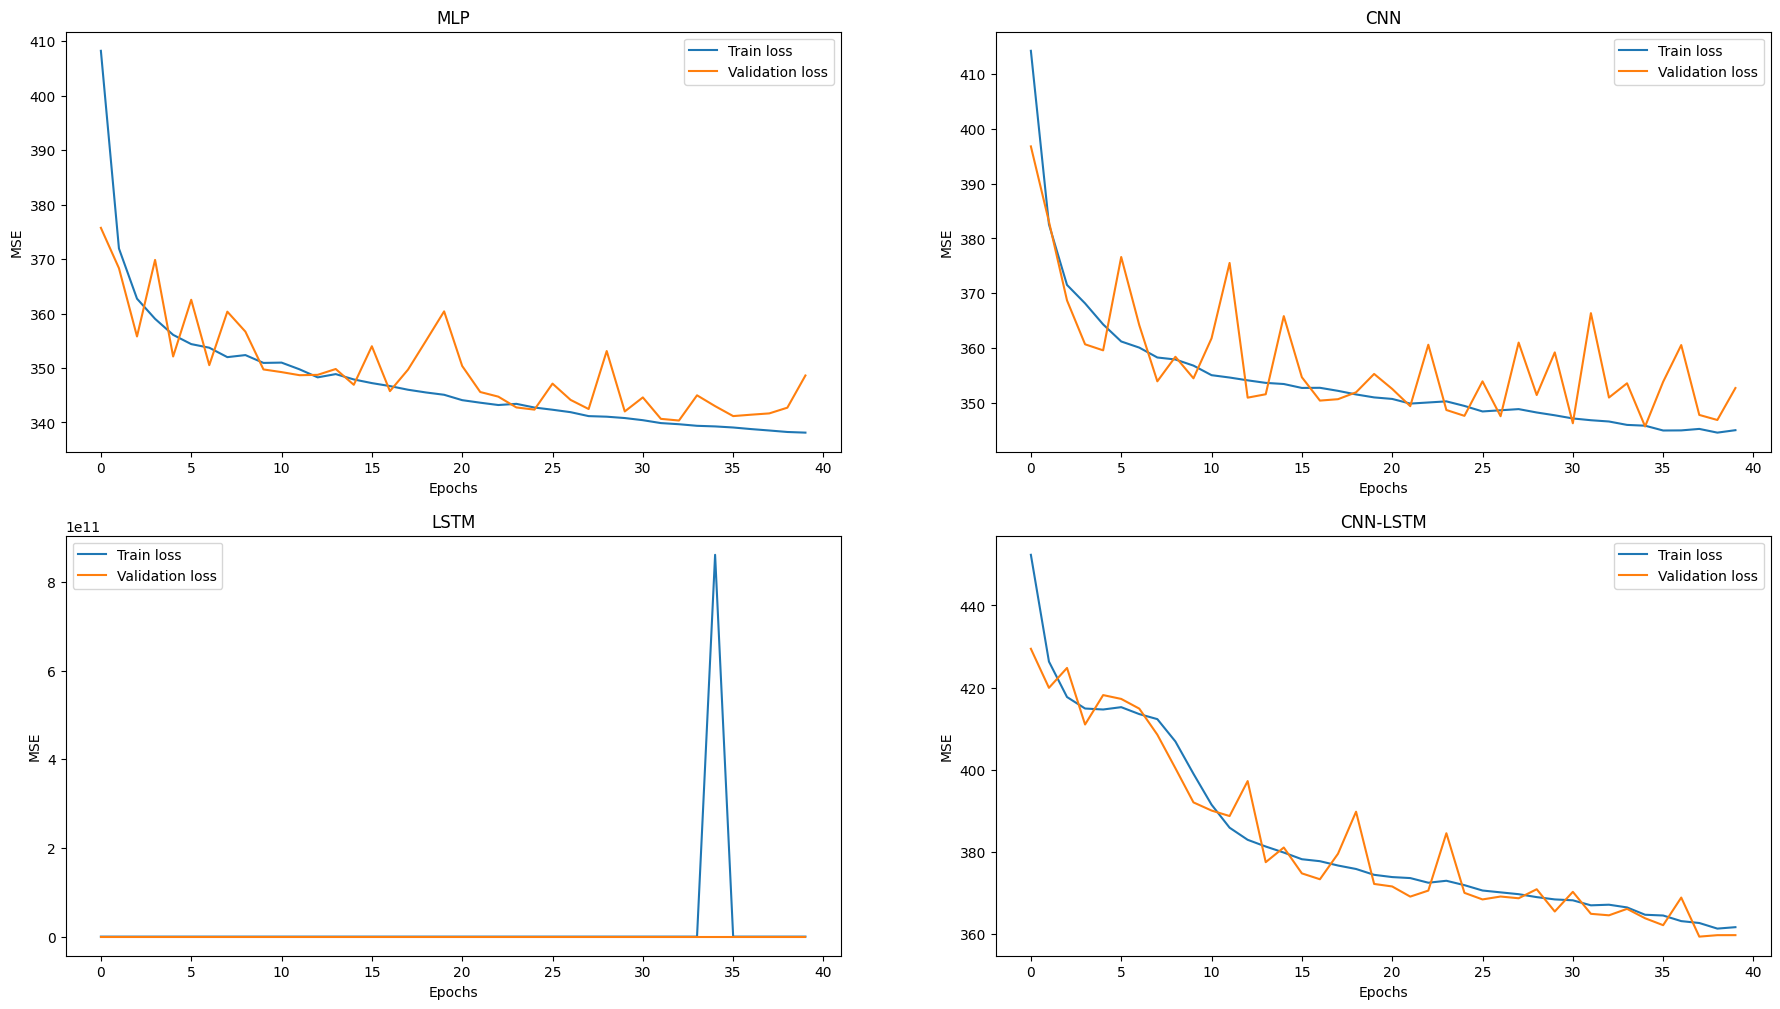

In [178]:
fig, axes = plt.subplots(2, 2, figsize = (22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [179]:
import numpy as np

mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('MLP Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('MLP Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

2099/2099 [==============================] - 2s 1ms/step
MLP Train rmse: 18.529280057200328
MLP Validation rmse: 18.6716442757358


In [180]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('CNN Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('CNN Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

2099/2099 [==============================] - 3s 1ms/step
CNN Train rmse: 18.660204763680373
CNN Validation rmse: 18.779450406113046


In [181]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('LSTM Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('LSTM Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

2099/2099 [==============================] - 3s 1ms/step
LSTM Train rmse: 20.692548430701972
LSTM Validation rmse: 18.779450406113046


In [182]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('CNN-LSTM Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('CNN-LSTM Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

2099/2099 [==============================] - 4s 2ms/step
CNN-LSTM Train rmse: 18.9673079185088
CNN-LSTM Validation rmse: 18.96548310159129


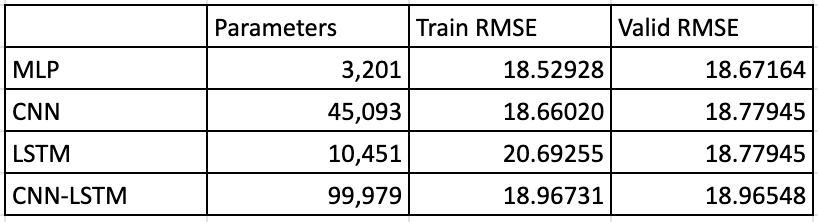

In [187]:
%matplotlib inline
from PIL import Image

Image.open("ModelComp.png") 

<b>Predictions for the Test Set using CNN-LSTM</b>

In [224]:
test2 = test.drop(['date'], axis=1)

In [231]:
X_test_series = test2.values.reshape((test2.shape[0], test2.shape[1], 1))
X_test_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))

In [235]:
predicted_output = model_cnn_lstm.predict(X_test_series_sub)

2099/2099 [==============================] - 4s 2ms/step


<b>Reference Links</b>
1. https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/
2. https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook